# Test different architectures

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

## Check for border effects. Does periodic Conv work?

In [4]:
DATADIR = '/data/stephan/WeatherBench/5.625deg/'

In [5]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't').drop('level')
valid_data = xr.merge([z500_valid, t850_valid])

In [9]:
preds_p = xr.open_dataset('/home/stephan/data/myWeatherBench/predictions/01-default.nc')
preds_np = xr.open_dataset('/home/stephan/data/myWeatherBench/predictions/09-no_periodic.nc')

In [10]:
compute_weighted_rmse(preds_p.isel(time=slice(0, None, 36)), valid_data).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 623.7
    t_rmse   float64 2.864

In [11]:
compute_weighted_rmse(preds_np.isel(time=slice(0, None, 36)), valid_data).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 632.4
    t_rmse   float64 2.876

In [12]:
rmse_p = compute_weighted_rmse(
    preds_p.isel(time=slice(0, None, 36)), valid_data, mean_dims=('time', 'level')).load()

In [13]:
rmse_np = compute_weighted_rmse(
    preds_np.isel(time=slice(0, None, 36)), valid_data, mean_dims=('time', 'level')).load()

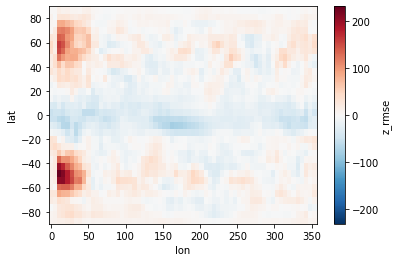

In [20]:
(rmse_np - rmse_p).z_rmse.plot()

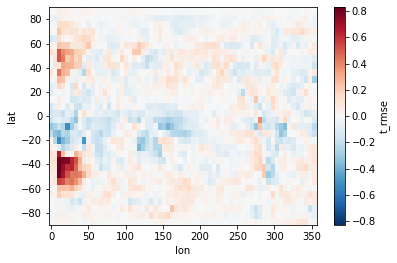

In [21]:
(rmse_np - rmse_p).t_rmse.plot()

## Add constants

In [5]:
hs = [read_pickle(
    f'/home/stephan/data/myWeatherBench/predictions/saved_models/{h}_history.pkl')
     for h in ['10-big_fc', '11-add_orography', '12-add_lat', '13-add_lsm']]

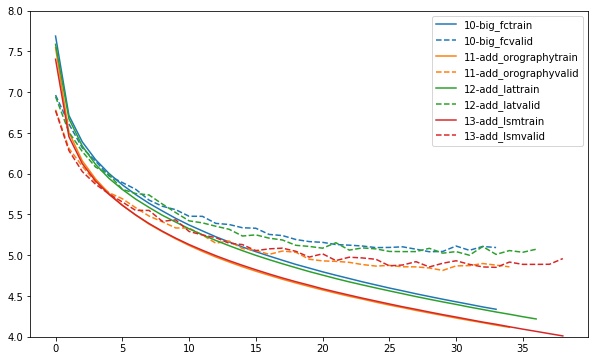

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip(hs, ['10-big_fc', '11-add_orography', '12-add_lat', '13-add_lsm'], 
                      sns.color_palette()):
    plot_hist(h, ax, (4, 8), name, valid=False, c=c)
    plot_hist(h, ax, (4, 8), name, train=False, c=c, ls='--')

## Resnet

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [5]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [6]:
output_vars = ['z_500', 't_850']

In [7]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [45]:
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [46]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 128

In [47]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 10:11:50.708981
DG normalize 10:11:50.743796
DG load 10:12:32.098280
Loading data into RAM
DG done 10:18:45.528048
DG start 10:18:45.528296
DG normalize 10:18:45.542130
DG load 10:18:45.548924
Loading data into RAM
DG done 10:18:56.752430
DG start 10:18:56.752744
DG normalize 10:18:56.770654
DG load 10:18:56.777926
Loading data into RAM
DG done 10:19:29.393363


In [48]:
class ChannelSlice(tf.keras.layers.Layer):

    def __init__(self, n_out, **kwargs):
        self.n_out = n_out
        super().__init__(**kwargs)

    def _slice(self, inputs):
        # Input: [samples, lat, lon, filters]
        return inputs[..., :self.n_out]

    def __call__(self, inputs):
        out = Lambda(self._slice)(inputs)
        return out

In [49]:
def build_resnet(filters, kernels, input_shape, activation='elu', dr=0, periodic=True):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        if periodic: x = PeriodicConv2D(f, k, activation=activation)(x)
        else: x = Conv2D(f, k, activation=activation, padding='same')(x)
        if dr > 0: x = Dropout(dr)(x)
    x = PeriodicConv2D(input_shape[2], kernels[-1])(x)
    x = Add()([input, x])
    output = ChannelSlice(filters[-1])(x)
    return keras.models.Model(input, output)

In [67]:
model = build_resnet(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)))

In [68]:
model.compile(keras.optimizers.Adam(lr), 'mse')

In [69]:
# model.summary()

In [70]:
from src.clr import LRFinder
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-6, maximum_lr=1e-2,
    lr_scale='exp', save_dir='./', verbose=0)

In [71]:
model.fit_generator(dg_train, steps_per_epoch=200000, epochs=1, 
                    callbacks=[lrf])

Epoch 1/1
   866/200000 [..............................] - ETA: 11:57:23 - loss: 415.7563

KeyboardInterrupt: 

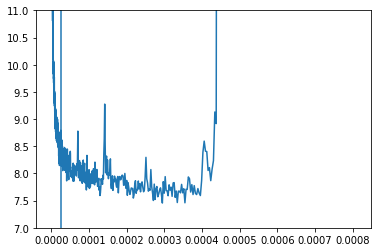

In [74]:
plt.plot(10**lrf.lrs, lrf.losses)
plt.ylim(7, 11)
plt.axvline(0.25e-4)

In [ ]:
lr = 0.25

## Get scores from multi-level runs

### Two level

In [97]:
var_dict = {'geopotential': ('z', [500, 850]), 'temperature': ('t', [500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars =  ['z_500', 't_850']
filters =  [128, 128, 128, 128, 128, 128, 2]
kernels =  [5, 5, 5, 5, 5, 5, 5]
lead_time =  72
norm_subsample = 60000

In [98]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [99]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [100]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 21:05:35.637813
DG normalize 21:05:35.657152
DG load 21:05:57.243387
Loading data into RAM
DG done 21:12:45.158860
DG start 21:12:45.190892
DG normalize 21:12:45.207618
DG load 21:12:45.217415
Loading data into RAM
DG done 21:12:48.148004


In [101]:
model = build_cnn(filters, kernels, 
                  input_shape=(32, 64, len(dg_train.data.level)))

In [102]:
model.compile('adam', 'mse')

In [103]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models//15_two_level.h5')

In [104]:
preds = create_predictions(model, dg_test)

In [106]:
z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}temperature_850', 't')

In [107]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(555.24154875)
Coordinates:
    level    int32 500
<xarray.DataArray 't_rmse' ()>
array(2.55548829)
Coordinates:
    level    int32 850


### Three level

In [108]:
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}

In [ ]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 21:19:44.336098
DG normalize 21:19:44.355051
DG load 21:21:52.063845
Loading data into RAM


In [ ]:
model = build_cnn(filters, kernels, 
                  input_shape=(32, 64, len(dg_train.data.level)))

In [ ]:
model.compile('adam', 'mse')

In [ ]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models//16_three_level.h5')

In [ ]:
preds = create_predictions(model, dg_test)

In [ ]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

## Check tisr normalizations

In [ ]:
tisr = xr.open_mfdataset